In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from src.preprocess import Preprocessor


uplift = pd.read_csv('./data/processed_data/pred_uplift.csv')
print(f'Total number of combinations: {uplift.shape[0]:,}')

preprocessor = Preprocessor()
prior_data, post_data = preprocessor.preprocess()
user_map, movie_map = preprocessor.id_mapping(df=post_data)

Total number of combinations: 28,838,017
Total number of ratings(post): 1,007,969
Total number of unique users(post): 1,651
Total number of unique movies(post): 17,467
Total number of ratings(prior): 8,812
Total number of unique users(prior): 1,104
Total number of unique movies(prior): 3,525


In [3]:
post_data['remap_userId'] = post_data['userId'].map(user_map)
post_data['remap_movieId'] = post_data['movieId'].map(movie_map)

print(f'Total number of combination (before filtering): {uplift.shape[0]:,}')
print(f'Total number of post ratings: {post_data.shape[0]:,}')

filtered_uplift = pd.merge(
    left=uplift, right=post_data, 
    on=['remap_userId', 'remap_movieId'], 
    how='left', indicator=True
)
filtered_uplift = filtered_uplift[filtered_uplift['_merge'] == 'left_only']
filtered_uplift = filtered_uplift.iloc[:, :5].reset_index(drop=True)

print(f'Total number of combinations (after filtering): {filtered_uplift.shape[0]:,}')

Total number of combination (before filtering): 28,838,017
Total number of post ratings: 1,007,969
Total number of combinations (after filtering): 27,830,048


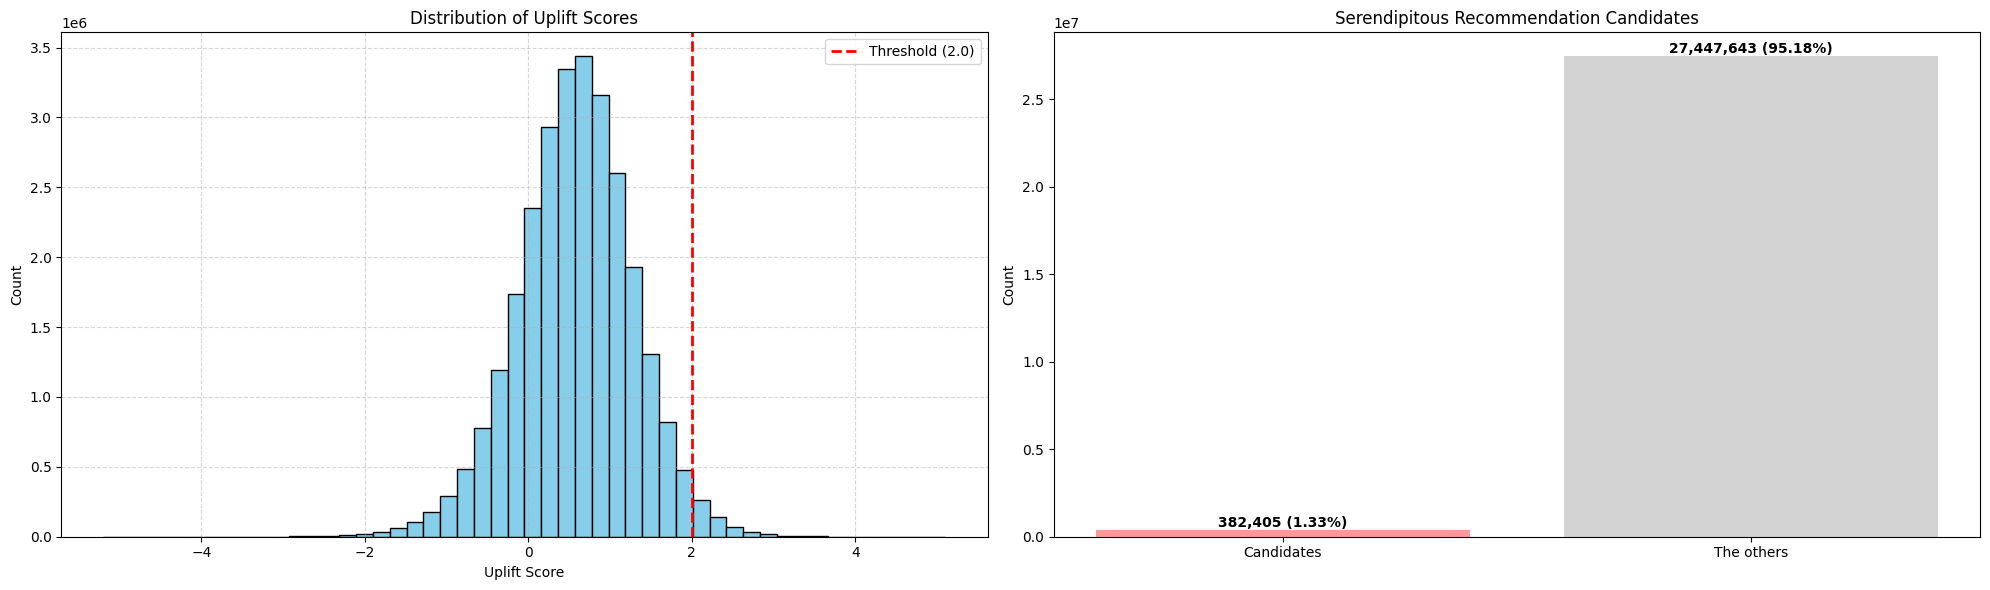

In [4]:
# uplift score distribution
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.grid(True, linestyle='--', alpha=0.5)
plt.hist(filtered_uplift['uplift_score'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=2.0, color='red', linestyle='--', linewidth=2, label='Threshold (2.0)')
plt.title('Distribution of Uplift Scores')
plt.xlabel('Uplift Score')
plt.ylabel('Count')
plt.legend()


uplift_threshold = 2.0
post_threshold = 4.0
serendipity_condition = (
    (filtered_uplift['uplift_score'] >= uplift_threshold) &
    (filtered_uplift['pred_post'] >= post_threshold)
)

over_threshold = filtered_uplift[serendipity_condition]
under_threshold = filtered_uplift[~serendipity_condition]

counts = [over_threshold.shape[0], under_threshold.shape[0]]
labels = ['Candidates', 'The others']

plt.subplot(1, 2, 2)
plt.title(f'Serendipitous Recommendation Candidates')
plt.ylabel('Count')

bars = plt.bar(labels, counts, color=['#ff9999', '#d3d3d3'])
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0, height, 
        f'{height:,} ({height / uplift.shape[0]:.2%})', 
        ha='center', va='bottom', fontweight='bold'
    )
plt.tight_layout()
plt.show()

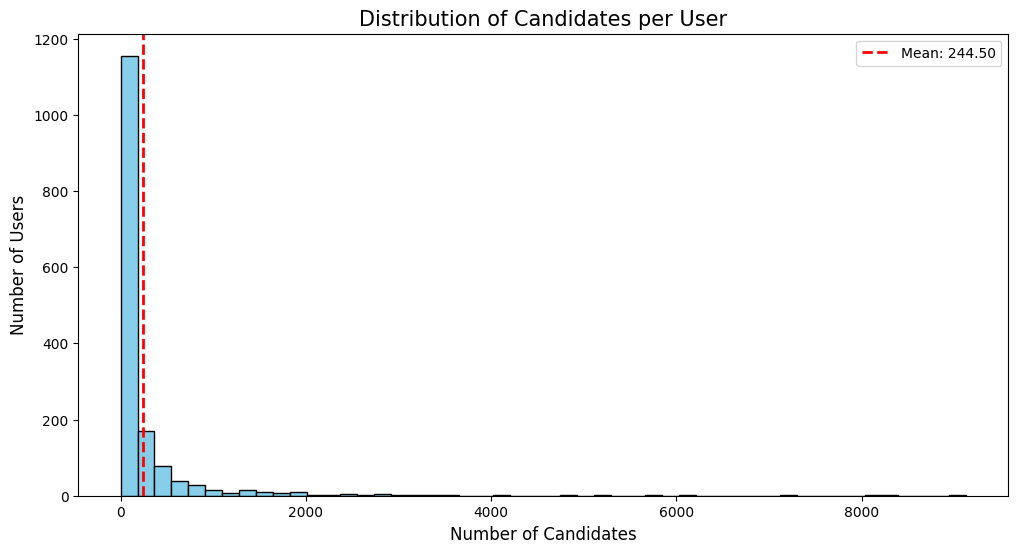

===== Statistics =====
Min: 1
Max: 9129
Mean: 244.5044757033248
Median: 47.0


In [5]:
# candidates per user
user_distribution = over_threshold['remap_userId'].value_counts()

plt.figure(figsize=(12, 6))
plt.hist(user_distribution, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Candidates per User', fontsize=15)
plt.xlabel('Number of Candidates', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
mean_count = user_distribution.mean()
plt.axvline(mean_count, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_count:.2f}')
plt.legend()
plt.show()

print('===== Statistics =====')
print(f'Min: {user_distribution.min()}')
print(f'Max: {user_distribution.max()}')
print(f'Mean: {user_distribution.mean()}')
print(f'Median: {user_distribution.median()}')